# Himalayan Mountaineering Analysis
## CPSC 322
## Fall, 2022
### Jaymin West, Dominic MacIsaac
---------------------------------------------------------

In [29]:
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyAssociationRuleMiner, MyRandomForrestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import eda_utils
importlib.reload(eda_utils)

import matplotlib.pyplot as plt

### Cleaning Data:

### Data Presentation Goals:
1. Summits by peak, year, nation, agency, season
1. Relationship between ratio of hired and summit success
1. Relationship of number of camps and summit success
1. Comparision of climbs with and without oxygen (and O2SLEEP)
1. Camps by peak
1. Camps by peak by agency
1. Camps by season 


<b>Class Distribution! Just total counts summit and not summit<b>

In [30]:
himalaya_table = MyPyTable()
himalaya_table.load_from_file("data/322-Final-Dataset.csv")

# Removing all rows with missing values
himalaya_table.remove_rows_with_missing_values("")

# Converting the SMTMEMBERS row to binary values as this will be 
#   what we use for predictions
himalaya_table.convert_row_to_binary("SUMMIT_SUCCESS", 0.0)
#himalaya_table.pretty_print()
himalaya_table = himalaya_table.combine_boolean_rows("SKI", "PARAPENTE", "TRUE")

In [31]:
def generate_freq_chart(table, col_name, xl, yl, min_value=0):
    temp_dict = eda_utils.get_col_items_count(table, col_name)
    temp_dict = {k:v for k, v in temp_dict.items() if v > min_value}
    eda_utils.make_freq_chart_from_dict(temp_dict, xl, yl)

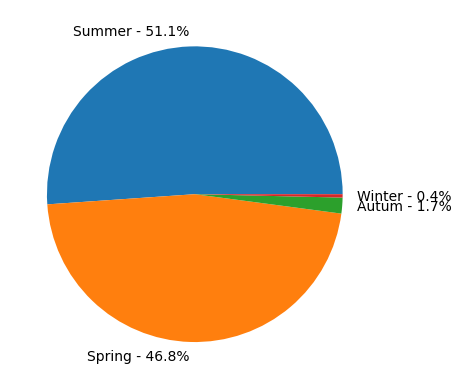

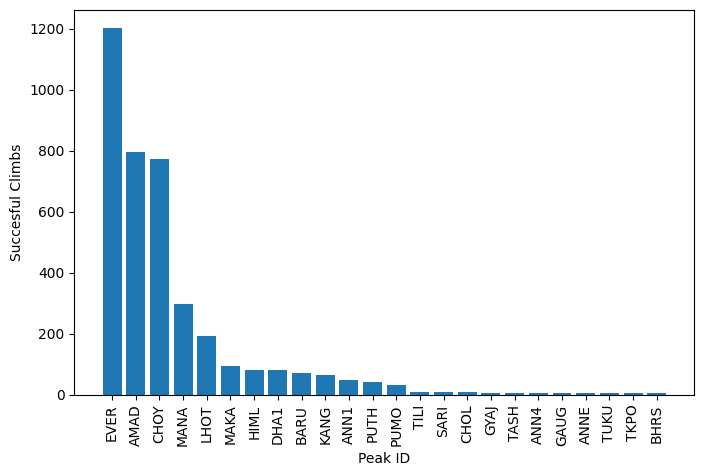

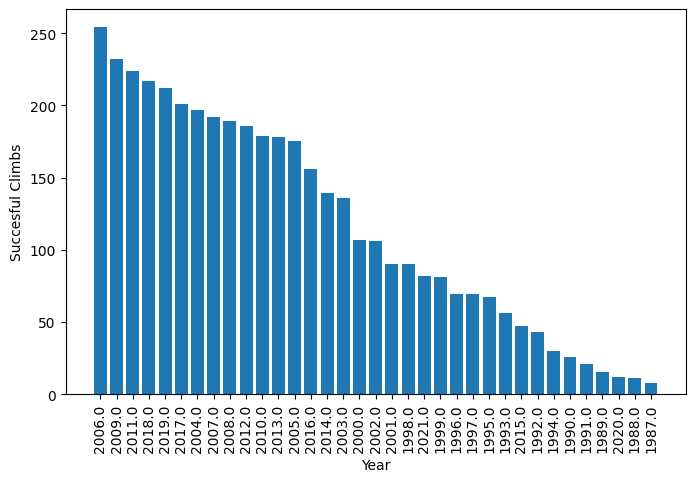

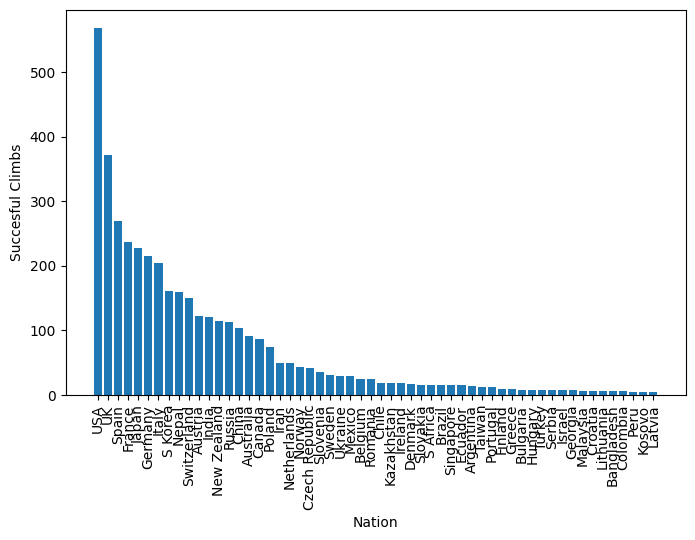

In [32]:
success_table = MyPyTable()
success_table.column_names = himalaya_table.column_names
success_table.data = [row for row in himalaya_table.data if row[-1] == 1]

l = success_table.get_column("SEASON")
freq_dict = {item:0 for item in l}

for item in l:
    freq_dict[item] += 1

freq_dict = dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))

vals = list(freq_dict.values())

s = sum(vals)
labels = ["Summer - %1.1f%%"%((vals[0] / s) *100), "Spring - %1.1f%%"%((vals[1] / s) *100), 
            "Autum - %1.1f%%"%((vals[2] / s) *100), "Winter - %1.1f%%"%((vals[3] / s) *100)]

plt.pie(vals, labels=labels)
plt.show()

generate_freq_chart(success_table, "PEAKID", "Peak ID", "Succesful Climbs", 4)
generate_freq_chart(success_table, "YEAR", "Year", "Succesful Climbs", 4)
generate_freq_chart(success_table, "NATION", "Nation", "Succesful Climbs", 4)

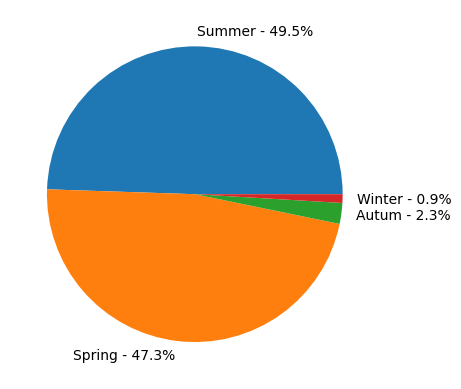

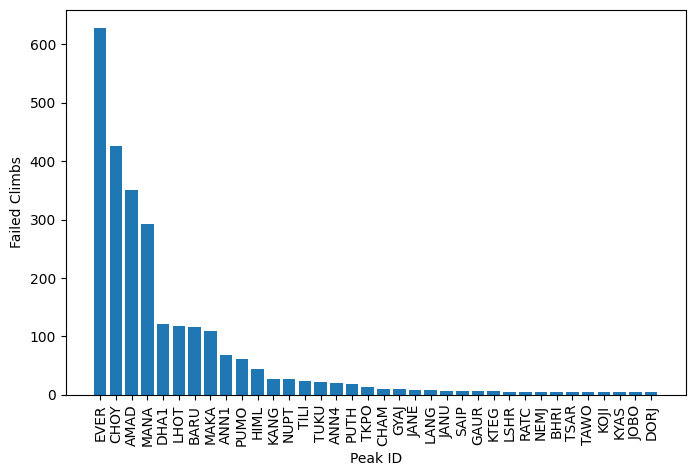

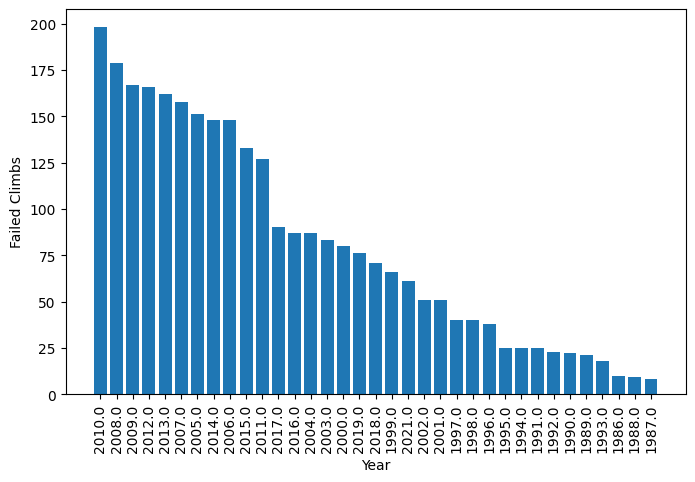

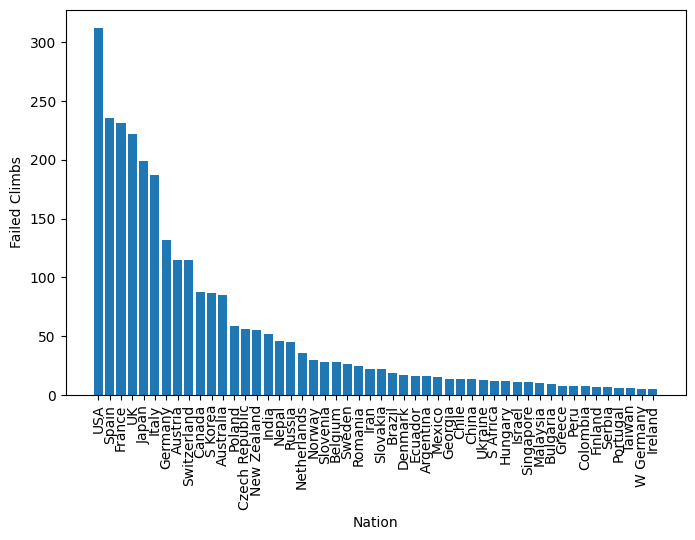

In [33]:
failure_table = MyPyTable()
failure_table.data = [row for row in himalaya_table.data if row[-1] == 0]
failure_table.column_names = himalaya_table.column_names

l = failure_table.get_column("SEASON")
freq_dict = {item:0 for item in l}

for item in l:
    freq_dict[item] += 1

freq_dict = dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))

vals = list(freq_dict.values())

s = sum(vals)
labels = ["Summer - %1.1f%%"%((vals[0] / s) *100), "Spring - %1.1f%%"%((vals[1] / s) *100), 
            "Autum - %1.1f%%"%((vals[2] / s) *100), "Winter - %1.1f%%"%((vals[3] / s) *100)]

plt.pie(vals, labels=labels)
plt.show()

generate_freq_chart(failure_table, "PEAKID", "Peak ID", "Failed Climbs", 4)
generate_freq_chart(failure_table, "YEAR", "Year", "Failed Climbs", 4)
generate_freq_chart(failure_table, "NATION", "Nation", "Failed Climbs", 4)

## Naive Bayes Classifying:

In [34]:
himalaya_nb_classifier = MyNaiveBayesClassifier()

X_train = [row[:-1] for row in himalaya_table.data]
# X_train = [himalaya_table.get_column("O2CLIMB")]
y_train = [row[-1] for row in himalaya_table.data]

classifier_stats = myutils.get_classifier_stats(himalaya_nb_classifier, X_train, y_train, 10)

myutils.print_stats("Naive Bayes Results %", classifier_stats)

Naive Bayes Results %
Accuracy:  59.5
Error Rate:  40.5
Precision:  53.300000000000004
Recall:  9.3
F1 Score:  15.9


## Decision Tree Classifying Without Attribute Selection:

In [35]:
himalaya_nb_classifier = MyDecisionTreeClassifier()

X_train = [row[1:12] for row in himalaya_table.data]
y_train = [row[-1] for row in himalaya_table.data]

classifier_stats = myutils.get_classifier_stats(himalaya_nb_classifier, X_train, y_train, 10)
16.2
myutils.print_stats("Decision Tree Results ALL ATTRIBUTES (split on Oxygen Usage) %", classifier_stats)

Decision Tree Results ALL ATTRIBUTES (split on Oxygen Usage) %
Accuracy:  16.6
Error Rate:  83.39999999999999
Precision:  48.8
Recall:  13.0
F1 Score:  20.5


In [36]:
himalaya_nb_classifier = MyDecisionTreeClassifier()

X_train = [[row[1], row[2], row[3], row[10], row[14]] for row in himalaya_table.data]
y_train = [row[-1] for row in himalaya_table.data]

classifier_stats = myutils.get_classifier_stats(himalaya_nb_classifier, X_train, y_train, 10)

myutils.print_stats("Decision Tree Results %\nTrained on YEAR, SEASON, HOST, 02CLIMB, COMMERCIALROUTE", classifier_stats)

Decision Tree Results %
Trained on YEAR, SEASON, HOST, 02CLIMB, COMMERCIALROUTE
Accuracy:  64.2
Error Rate:  35.8
Precision:  55.60000000000001
Recall:  69.6
F1 Score:  60.9


## Rule Mining:

In [37]:
# himalaya_table.convert_to_string()
# rules_dataset = himalaya_table.data

# X = [rules_dataset[row] for row in range(len(rules_dataset))]
# for row in range(len(X)):
#     for col in range(len(himalaya_table.column_names)):
#         X[row][col] = himalaya_table.column_names[col] + "=" + X[row][col]

# himalaya_arm = MyAssociationRuleMiner()
# himalaya_arm.fit(rules_dataset)
# himalaya_arm.print_association_rules()


## Random Forrest Classification:

In [44]:
# 1. divide your dataset into a test set (passed to predict) and a "remainder set" (passed into fit())
# 2. generate N bootstrapped samples (N as in the number of initila trees in the ensemble) to create N trees
# 3. compare the performance of each tree on its validation set using some metric (accuracy/recall/precision)
# 4. for each instances of the test set, get a prediciton from the ensemle using majority voting over the M trees
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyAssociationRuleMiner, MyRandomForrestClassifier

himalaya_table.convert_to_string()

X_train = [row[1:12] for row in himalaya_table.data]
y_train = [row[-1] for row in himalaya_table.data]

himalaya_rf = MyRandomForrestClassifier(10, 4, 4)
himalaya_rf.fit(X_train, y_train)
himalaya_rf.predict(X_train)

['2018.0', '11/22/18', '2.0', 'FALSE']
Score:  0.4217102694260055
['1993.0', '3.0', 'France', '5.0']
Score:  0.4431862553689965
['3.0', '09/15/14', 'False', 'TRUE']
Score:  0.4271768840296759
['04/10/14', '1.0', '1.0', '1.0']
Score:  0.43811011323701676
['09/14/13', 'False', '4.0', 'FALSE']
Score:  0.43811011323701676
['2014.0', '2.0', '3.0', 'TRUE']
Score:  0.442405310425615
['11/19/09', '2.0', 'FALSE', 'FALSE']
Score:  0.4396720031237798
['09/11/18', 'False', '3.0', 'TRUE']
Score:  0.4470909800859039
['2011.0', '1.0', 'False', 'FALSE']
Score:  0.44357672784068725
['09/08/07', '1.0', 'FALSE', 'FALSE']
Score:  0.4470909800859039


['0']